## Assignment 2: Network Safety


#### CSC 180  Intelligent Systems (Spring 2020)

#### Ace English

# Helpful Functions for Tensorflow

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    

# Metrics: 

For any type of classification neural network:

* **Accuracy** 
* **Precision** 
* **Recall** 
* **F1 Score** 
* **Log Loss**
* **Confusion Matrix** 
* **ROC Curve** 

The code used to produce Confusion matrix and ROC curve is shown here:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Visualizing binary classification models


Binary classification is used to create a model that classifies between only two classes.  These two classes are often called "positive" and "negative". 


In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Set the desired TensorFlow output level for this example
# tf.logging.set_verbosity(tf.logging.ERROR)


df = pd.read_csv("network_intrusion_data.csv")
df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


## Data Examination
Now we clean the data. Part of this process is checking for redundant records and records with missing values. Like normal, we will encode categorical data and normalizing numerical data.

Data types of each row:

In [4]:
datatype={}

datatype["duration"] = "continuous"
datatype["protocol_type"] = "symbolic"
datatype["service"] = "symbolic"
datatype["flag"] = "symbolic"
datatype["src_bytes"] = "continuous"
datatype["dst_bytes"] = "continuous"
datatype["land"] = "symbolic"
datatype["wrong_fragment"] = "continuous"
datatype["urgent"] = "continuous"
datatype["hot"] = "continuous"
datatype["num_failed_logins"] = "continuous"
datatype["logged_in"] = "symbolic"
datatype["num_compromised"] = "continuous"
datatype["root_shell"] = "continuous"
datatype["su_attempted"] = "continuous"
datatype["num_root"] = "continuous"
datatype["num_file_creations"] = "continuous"
datatype["num_shells"] = "continuous"
datatype["num_access_files"] = "continuous"
datatype["num_outbound_cmds"] = "continuous"
datatype["is_host_login"] = "symbolic"
datatype["is_guest_login"] = "symbolic"
datatype["count"] = "continuous"
datatype["srv_count"] = "continuous"
datatype["serror_rate"] = "continuous"
datatype["srv_serror_rate"] = "continuous"
datatype["rerror_rate"] = "continuous"
datatype["srv_rerror_rate"] = "continuous"
datatype["same_srv_rate"] = "continuous"
datatype["diff_srv_rate"] = "continuous"
datatype["srv_diff_host_rate"] = "continuous"
datatype["dst_host_count"] = "continuous"
datatype["dst_host_srv_count"] = "continuous"
datatype["dst_host_same_srv_rate"] = "continuous"
datatype["dst_host_diff_srv_rate"] = "continuous"
datatype["dst_host_same_src_port_rate"] = "continuous"
datatype["dst_host_srv_diff_host_rate"] = "continuous"
datatype["dst_host_serror_rate"] = "continuous"
datatype["dst_host_srv_serror_rate"] = "continuous"
datatype["dst_host_rerror_rate"] = "continuous"
datatype["dst_host_srv_rerror_rate"] = "continuous"
datatype["outcome"] = "symbolic"

# Search for duplicates and remove

In [5]:
df_dupes=df[df.duplicated()]
print ("Removing ",df_dupes.shape[0]," duplicate entries...")
df_unique=df.drop_duplicates()
print(df_unique)

Removing  348435  duplicate entries...
        duration protocol_type service flag  src_bytes  dst_bytes  land  \
0              0           tcp    http   SF        239        486     0   
1              0           tcp    http   SF        235       1337     0   
2              0           tcp    http   SF        219       1337     0   
3              0           tcp    http   SF        217       2032     0   
4              0           tcp    http   SF        217       2032     0   
...          ...           ...     ...  ...        ...        ...   ...   
494015         0           tcp    http   SF        310       1881     0   
494016         0           tcp    http   SF        282       2286     0   
494017         0           tcp    http   SF        203       1200     0   
494018         0           tcp    http   SF        291       1200     0   
494019         0           tcp    http   SF        219       1234     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_count

Next I want to check all columns to see what the expected outputs are and if any of them are invalid.

In [6]:
for (colName, colData) in df_unique.iteritems():
    valueCount=colData.drop_duplicates()
    print(colName, "-",valueCount.size, valueCount.values)

duration - 2495 [   0    1   79 ... 2695 2751  120]
protocol_type - 3 ['tcp' 'udp' 'icmp']
service - 66 ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag - 11 ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
src_bytes - 3300 [239 235 219 ... 500 484 475]
dst_bytes - 10725 [  486  1337  2032 ... 34557 10592 13828]
land - 2 [0 1]
wrong_fragment - 3 [0 1 3]
urgent - 4 [0 2 1 3]
hot - 22 [ 0  1  3 19  6  4 30 24 14 18  2  5 17 22  7 16 12 20 10 28 

outcome - 23 ['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']


All this data looks valid.

`num_outbound_cmds` and `is_host_login` both have only 1 entry type, so they can be dropped.
Next I want to see what kind of sample sizes we can work with which each of these, so instead of just returning each list I want to produce a count.

In [7]:
#drop worthless data
df_unique=df_unique.drop(['is_host_login','num_outbound_cmds'], axis=1)

#check values count
i=0
for (colName, colData) in df_unique.iteritems():
    value_counts=colData.value_counts();
    print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
    print(value_counts.sort_values(ascending=False))
    print()
    i=i+1

Name:  duration  Type:  duration Size: 2495
0        134974
1          2441
2           853
3           604
5           407
          ...  
3171          1
5344          1
3299          1
17770         1
6543          1
Name: duration, Length: 2495, dtype: int64

Name:  protocol_type  Type:  protocol_type Size: 3
tcp     130912
udp      12267
icmp      2406
Name: protocol_type, dtype: int64

Name:  service  Type:  service Size: 66
http        62053
private     49057
smtp         9721
domain_u     5425
other        4769
            ...  
X11            11
tim_i           5
pm_dump         1
red_i           1
tftp_u          1
Name: service, Length: 66, dtype: int64

Name:  flag  Type:  flag Size: 11
SF        87458
S0        42278
REJ       14712
RSTO        569
RSTR        425
S1           57
SH           34
S2           24
RSTOS0       11
S3           10
OTH           7
Name: flag, dtype: int64

Name:  src_bytes  Type:  src_bytes Size: 3300
0        57872
147       1962
105       1467

Here we see that several of the fields have a huge disparity in volume. `urgent` is almost entirely 0. Several other fields have a huge majority of one field with other fields being rare. However, several of these may be crucial for finding attacks.


`wrong_fragment`, `num_failed_logins`, `num_compromised`, `hot`, `root_shell`, `su_attempted`, `num_root`, `num_file_creations`, `num_shells`, `is_guest_login`, `num_access_files`
## Separating attacks from normal

In [8]:
outliers=['outcome','land','wrong_fragment', 'num_failed_logins', 'num_compromised', 'hot', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'is_guest_login', 'num_access_files']
df_normals=df_unique[df_unique['outcome']=='normal.']
df_attacks=df_unique.drop(df_normals.index)

i=0
for (colName, colData) in df_attacks.iteritems():
    if(colName in outliers):
        value_counts=colData.value_counts();
        print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
        print(value_counts.sort_values(ascending=False))
        print()
    i=i+1

Name:  land  Type:  land Size: 2
0    57735
1       19
Name: land, dtype: int64

Name:  wrong_fragment  Type:  wrong_fragment Size: 3
0    56633
3      910
1      211
Name: wrong_fragment, dtype: int64

Name:  hot  Type:  hot Size: 14
0     56339
2       917
28      274
1       133
3        34
5        16
4        15
20        9
6         8
19        5
7         1
10        1
15        1
18        1
Name: hot, dtype: int64

Name:  num_failed_logins  Type:  num_failed_logins Size: 3
0    57701
1       52
5        1
Name: num_failed_logins, dtype: int64

Name:  num_compromised  Type:  num_compromised Size: 10
0     56832
1       901
2         8
4         7
3         1
5         1
6         1
38        1
16        1
22        1
Name: num_compromised, dtype: int64

Name:  root_shell  Type:  root_shell Size: 2
0    57722
1       32
Name: root_shell, dtype: int64

Name:  su_attempted  Type:  su_attempted Size: 2
0    57753
1        1
Name: su_attempted, dtype: int64

Name:  num_root  Type:  

Surprisingly a lot of these values are still disproportionate even among errors only. Many of them will get dropped later.

`num_failed_logins`,`root_shell`,`su_attempted`,`num_root`, `num_file_creations`,`num_shells`, `num_access_files` seem irrelevent and have very little data to go off of.

I am also going to apply **downsampling** here so that the quantity of good connections more closely matches the volume of attacks.

In [9]:
drop_columns=['urgent','land','num_failed_logins', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files']
#Model using fewer of the good samples - same number as most common error
df_downsampled=df_normals.sample(51820).append(df_attacks)
#model dropping rows that might be irrelevent
df_slim=df_unique.drop(drop_columns,axis=1)
#model dropping irrelevent rows AND using downsampling
df_slim_downsampled=df_downsampled.drop(drop_columns,axis=1)

print(df_unique.shape)
print(df_downsampled.shape)
print(df_slim.shape)
print(df_slim_downsampled.shape)

print (df_slim_downsampled['outcome'].value_counts())


(145585, 40)
(109574, 40)
(145585, 31)
(109574, 31)
normal.             51820
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: outcome, dtype: int64


Next I'm going to format the arrays in a useful way. To encode output as safe/unsafe, I will add another layer "attack" and drop the layer "outcome" (I supsect the neural network will rely too heavily on it if I leave it in.)

In [10]:
def make_binary(string):
    if(string=="normal."):
        return 0
    else:
        return 1

y=df_slim_downsampled["outcome"].map(make_binary)

y_test_model=df_slim["outcome"].map(make_binary)
labels=["good","attack"]

print (y.value_counts())


1    57754
0    51820
Name: outcome, dtype: int64


## Normalization and one-hot encoding

For `outcome` we don't care what the error code is (just that it is not normal)

In [11]:
#get arrays for training
df_data=df_slim_downsampled.drop(["outcome"], axis=1)

#prep for model
for (name,column) in df_data.iteritems():
    if(datatype[name]=='continuous'):
        encode_numeric_zscore(df_data, name)
    else:
        encode_text_dummy(df_data,name)

#get arrays for testing
df_test=df_slim.drop(["outcome"], axis=1)
for (name,column) in df_test.iteritems():
    if(datatype[name]=='continuous'):
        encode_numeric_zscore(df_test, name)
    else:
        encode_text_dummy(df_test,name)
        
print("Training data shape (downsampled)", df_data.shape)
print("Testing data shape", df_test.shape)

Training data shape (downsampled) (109574, 109)
Testing data shape (145585, 109)


In [12]:
#drop missing data
df_dropped=df_data.dropna()
print(df_dropped.shape)
print(df_data.shape)

(109574, 109)
(109574, 109)


In [16]:
 # Split into train/test
x_train, x_test, y_train, y_test = train_test_split(df_data, y, test_size=0.25, random_state=42) 
#For testing data, use the entire set, not just the weighted subset

#x_throwaway, x_test, y_throaway, y_test = train_test_split(df_test, y_test_model, test_size=0.25, random_state=42) 

# Model Training
## KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Testing

In [18]:
pred = knn.predict(x_test)
pred

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

# Visualization

[[13013    20]
 [   28 14333]]
Plotting confusion matrix


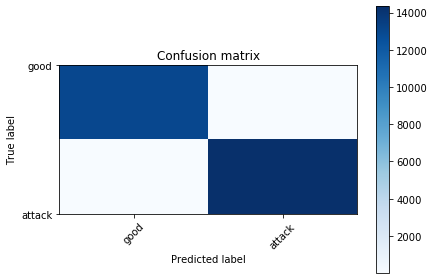

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13033
           1       1.00      1.00      1.00     14361

    accuracy                           1.00     27394
   macro avg       1.00      1.00      1.00     27394
weighted avg       1.00      1.00      1.00     27394



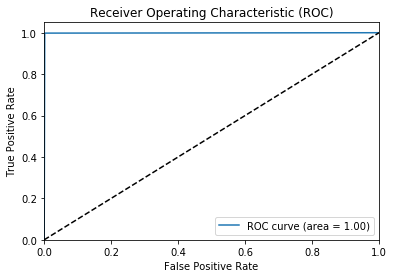

In [19]:
import numpy as np

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, pred)
print(cm)


print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, labels)
plt.show()

print(classification_report(y_test, pred))
plot_roc(pred,y_test)

## Random testing
> Debugging by hand is like trying to find tiny holes in a dartboard covered in cloth...and you only have 5 darts.

In [21]:
#indexes=[36176,7768,140930,15584,19050,108730]
import random
indexes=[]
for i in range(10):
    indexes.append(random.randrange(y_test_model.shape[0]))
print(indexes)

[8693, 48520, 14539, 9476, 40329, 136704, 132266, 87516, 1731, 17530]


In [22]:
#test a single sample
for i in indexes:
    sample=df_test.values[i].reshape(1, -1)
    print("Actual: ",df_slim.values[i])
    print("Predicted: ",knn.predict(sample))
    print()

Actual:  [0 'tcp' 'http' 'SF' 216 1021 0 0 1 0 0 3 27 0.0 0.0 0.0 0.0 1.0 0.0 0.07
 146 255 1.0 0.0 0.01 0.03 0.0 0.0 0.0 0.0 'normal.']
Predicted:  [0]

Actual:  [0 'tcp' 'private' 'S0' 0 0 0 0 0 0 0 112 6 1.0 1.0 0.0 0.0 0.05 0.06 0.0
 255 6 0.02 0.07 0.0 0.0 1.0 1.0 0.0 0.0 'neptune.']
Predicted:  [1]

Actual:  [0 'tcp' 'http' 'SF' 325 471 0 0 1 0 0 16 17 0.0 0.0 0.0 0.0 1.0 0.0 0.12
 68 255 1.0 0.0 0.01 0.06 0.0 0.0 0.0 0.0 'normal.']
Predicted:  [0]

Actual:  [0 'tcp' 'http' 'SF' 340 1804 0 0 1 0 0 10 10 0.0 0.0 0.0 0.0 1.0 0.0 0.0
 70 255 1.0 0.0 0.01 0.02 0.0 0.0 0.0 0.0 'normal.']
Predicted:  [0]

Actual:  [2 'tcp' 'smtp' 'SF' 22532 1437 0 0 1 0 0 1 2 0.0 0.0 0.0 0.0 1.0 0.0 1.0
 131 151 0.6 0.04 0.01 0.01 0.0 0.0 0.02 0.03 'normal.']
Predicted:  [0]

Actual:  [0 'tcp' 'private' 'REJ' 0 0 0 0 0 0 0 89 17 0.0 0.0 1.0 1.0 0.19 0.06 0.0
 255 17 0.07 0.06 0.0 0.0 0.0 0.0 1.0 1.0 'neptune.']
Predicted:  [1]

Actual:  [0 'tcp' 'private' 'REJ' 0 0 0 0 0 0 0 132 16 0.0 0.0 1.0 1.0 0.12